In [6]:
# NOT WORKING: need to fix forward (unconditional generation)

In [9]:
import os
import sys
sparse_multiview = f'{os.getcwd()}/../sparse_multiview'
sys.path.append(sparse_multiview)
from multiview import *
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
args = OmegaConf.load(f'{sparse_multiview}/configs/views5.yaml')

In [10]:
model = MultiViewDiffusionModel(args).cuda()
model.eval()
dataset = MultiViewDataset(args)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    #pin_memory=True
)
batch = next(iter(dataloader))

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


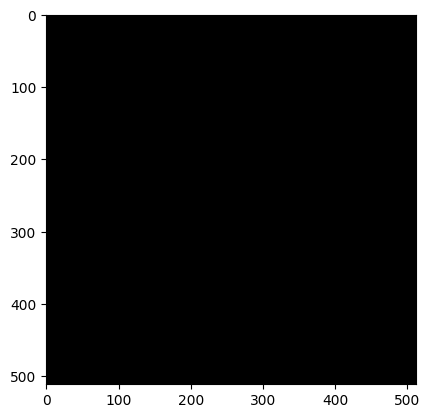

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


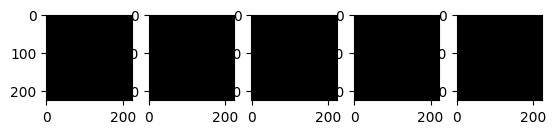

In [11]:
image = batch['image'].squeeze(0).permute((1, 2, 0))
views = [img.permute((1, 2, 0)) for img in batch['views'].squeeze(0)]
plt.imshow(image)
plt.show()
fig, axs = plt.subplots(1, len(views))
for i, view in enumerate(views):
    axs[i].imshow(view)
plt.show()

In [12]:
images = model.forward({k:v.cuda() for k,v in batch.items()})
images[0]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_237297/2046700752.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_237297/2046700752.py'                       │
│                                                                                                  │
│ /home/akirchme/art3d/art3d-multiviewdepthdiffusion/sparse_multiview/multiview.py:287 in forward  │
│                                                                                                  │
│   284 │   def forward(self, batch):                                                              │
│   285 │   │   with torch.inference_mode():                                                       │
│   286 │   │   │   batch = self.multiview_encoder(batch)                                          │
│ ❱ 287 │   │   │   return self.pipe(prompt=None, prompt_embeds=batch['context'], do_classifier_   │
│   288                                                                                            │
│                                                                                                  │
│ /home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/torch/autograd/grad_mode.py:27 in  │
│ decorate_context                                                                                 │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: StableDiffusionPipeline.__call__() got an unexpected keyword argument 'do_classifier_free_guidance'

In [ ]:
model.multiview_encoder.mae_image_mask_ratio = 0
images, attention_maps = model.forward_with_crossattention({k:v.cuda() for k,v in batch.items()})
attention_maps = attention_maps.detach().cpu()
orig_image = images[0]
orig_image

In [ ]:
dataset.num_views_per_inst

In [ ]:
# Inspired by 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/notebooks/explain.ipynb
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/vis_utils.py 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/ptp_utils.py

import ptp_utils
from vis_utils import show_image_relevance
# show spatial attention for indices of tokens to strengthen
n_tokens = attention_maps.shape[2]
res = 16

mae = model.multiview_encoder.model
m = n_tokens // dataset.num_views_per_inst

context = batch['views']
context = context.view(-1, *context.shape[2:])
context_tokens = mae.patchify(context.cuda()).reshape(-1, 768).cpu().numpy()
for view in range(dataset.num_views_per_inst):
    images = []
    for i in range(view*m, view*m+m):
        image = attention_maps[:, :, i]
        image = show_image_relevance(image, orig_image)
        image = image.astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((res ** 2, res ** 2)))
        images.append(image)
    ptp_utils.view_images(np.stack(images[1:11], axis=0))
    plt.show()
    
    imgs = context_tokens[:10].reshape(-1, 3, 16, 16).transpose((0,2,3,1))
    #print(imgs[0])
    fig, axs = plt.subplots(1, 10)
    for i in range(10):
        axs[i].imshow(imgs[i])
    plt.show()